# Blood donor dataset

In [70]:
import pandas as pd
import numpy as np

from download import download
import matplotlib.pyplot as plt
from graphviz import Source
from IPython.display import SVG
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.ticker as mtick
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.pipeline import Pipeline
import time

import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib notebook

pd.set_option("display.max_rows", None, "display.max_columns", None)

The dataset is made of 615 patients and 14 features.
The dataset without missing values is made of 589 patients and 13 features.



<IPython.core.display.Javascript object>


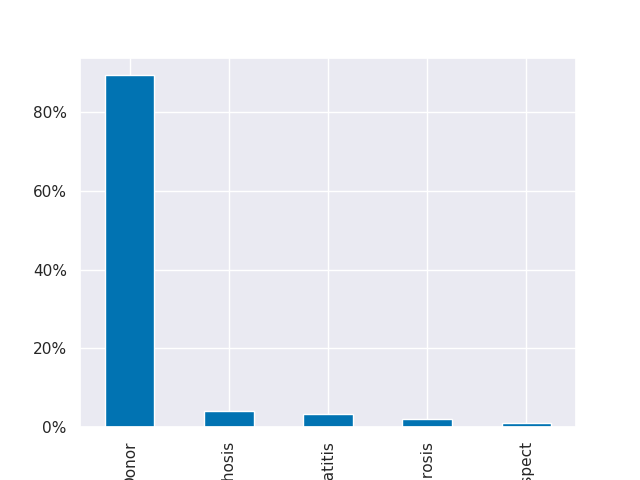

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv"
script_dir = os.path.abspath("")
results_dir = os.path.join(script_dir, 'hcvdat0.csv')

download(url, results_dir, replace=False, verbose=False)
blood = pd.read_csv('hcvdat0.csv')

print("The dataset is made of {} patients and {} features.".format(
    blood.shape[0], blood.shape[1]))

blood.dropna(inplace=True)
blood.drop(blood.columns[0], axis=1, inplace=True)
print("The dataset without missing values is made of {} patients and {} features.\n".format(
    blood.shape[0], blood.shape[1]))

blood.replace({'Category': {'0=Blood Donor': "Donor", '0s=suspect Blood Donor': "Suspect",
                            '1=Hepatitis': "Hepatitis", '2=Fibrosis': "Fibrosis",
                            '3=Cirrhosis': "Cirrhosis"}}, inplace=True)

count = blood['Category'].value_counts() / blood.shape[0] * 100

plt.figure()
f = count.plot(kind='bar')
f.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [3]:
blood.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [4]:
col_names = blood.columns

def colorize(sth):
    if sth in col_names:
        return('\x1b[6;37;40m' + str(sth) + '\x1b[0m')

idx = -1
for idx_, name in enumerate(col_names):
    new_idx = idx_
    if new_idx != idx:
        print("\n" + colorize(name) + "----------------------\n ==========================")
    print(blood[name].unique())


Category----------------------
['Donor' 'Suspect' 'Hepatitis' 'Fibrosis' 'Cirrhosis']

Age----------------------
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 76 77 74 23 25 27 29]

Sex----------------------
['m' 'f']

ALB----------------------
[38.5 46.9 43.2 39.2 41.6 46.3 42.2 50.9 42.4 44.3 46.4 36.3 39.  38.7
 41.8 40.9 45.2 36.6 42.  46.7 42.7 43.4 40.5 44.8 42.6 29.  44.6 46.8
 46.1 43.6 37.5 42.1 44.7 41.5 48.7 47.3 44.5 47.4 51.  27.8 45.5 41.7
 45.9 53.  47.8 48.9 31.4 42.9 44.  47.9 38.6 51.2 41.9 50.4 33.9 40.8
 48.1 39.9 41.2 48.4 38.3 45.1 38.8 47.  43.9 36.  45.7 45.8 41.4 45.
 39.1 45.4 42.3 40.2 53.3 37.4 45.3 44.1 37.8 38.1 46.2 37.  39.7 54.4
 39.4 42.8 44.4 38.4 35.5 48.6 46.5 36.2 40.3 35.7 37.9 47.7 49.1 43.
 49.7 37.3 51.8 49.5 48.  48.3 36.7 55.4 42.5 38.2 43.1 46.  40.  46.6
 43.5 43.8 38.  36.8 47.2 50.8 82.2 39.3 37.2 40.7 41.  49.  49.2 47.6
 28.1 59.7 43.3 41.3 39.8 40.4 41.1 34.3 38.

## Modelisation goal

The goal is here is to determine wether a patient can be classified as a blood donor or identify the hepatitis C and its current state of evolution.

The dataset is made of numerical variables except for the target feature (the category) and the sex of the patient.

We find ourselves in a classification problem. Let's test different methods.

In [132]:
X, y = blood.drop(blood.columns[0], axis=1), blood["Category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

## Logistic regression


In [63]:
quanti = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT']
quali = ['Sex']

quanti_pipe = Pipeline([('scaler', StandardScaler())])

quali_pipe = Pipeline([('onehot', OneHotEncoder(drop='first'))])

quantiquali_pipe = ColumnTransformer(
    transformers=[
        ('quanti', quanti_pipe, quanti),
        ('quali', quali_pipe, quali)])

logi_pipe = Pipeline(steps=[('preprocess', quantiquali_pipe),
                           ('logi', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
logi_pipe.fit(X_train, y_train)
print("model score: %.3f" % logi_pipe.score(X_test, y_test))

model score: 0.924


## Multi
There's no need to standardize our data but let's keep working with it anyway.

In [64]:
knn_pipe = Pipeline(steps=[('preprocess', quantiquali_pipe),
                           ('knn', KNN())])

dt_pipe = Pipeline(steps=[('preprocess', quantiquali_pipe),
                           ('dt', DecisionTreeClassifier(criterion="entropy"))])

rf_pipe = Pipeline(steps=[('preprocess', quantiquali_pipe),
                           ('rf', RandomForestClassifier(n_estimators=25))])

In [68]:
classifiers = [("logistic regression", logi_pipe),
               ("knn", knn_pipe),
               ("Decision tree", dt_pipe),
               ("Random Forest", rf_pipe)]

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("{:s} : {:.4f}".format(name, accuracy_score(y_pred, y_test)))

logistic regression : 0.9237
knn : 0.9153
Decision tree : 0.8898
Random Forest : 0.9322


<IPython.core.display.Javascript object>


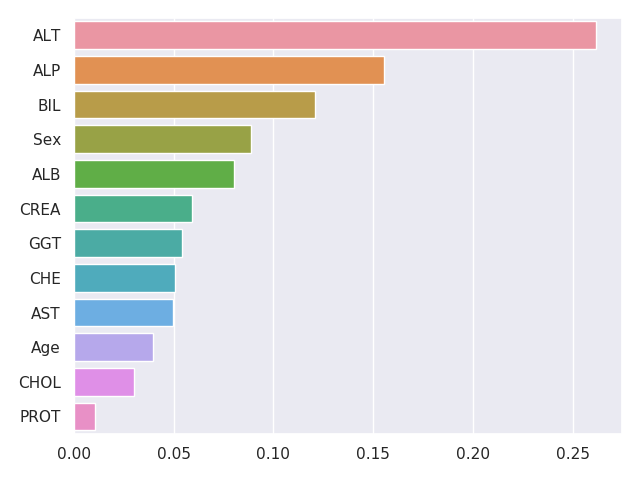

In [69]:
importances = pd.Series(data=rf_pipe['rf'].feature_importances_,
                        index= X.columns)

importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
sns.barplot(importances.values,importances.index)
plt.tight_layout()
plt.show()

## Bench everyone

In [433]:
def get_acc(clf, X_test, y_test):
    return accuracy_score(clf.predict(X_test), y_test)


def training(clf, X_train, y_train):
    clf.fit(X_train, y_train)


def prediction(clf, X_test):
    clf.predict(X_test)


def bench_one(clf, X, y, J=50):
    time_fit = []
    time_predict = []
    time_accuracy, accuracy = [], []
    for j in range(J):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=.2, stratify=y)

        start = time.perf_counter()
        fit_val = training(clf, X_train, y_train)
        fit_ = time.perf_counter()

        pred_val = prediction(clf, X_test)
        pred = time.perf_counter()

        acc_val = get_acc(clf, X_test, y_test)
        acc = time.perf_counter()

        time_fit.append(fit_ - start);
        time_predict.append(pred - fit_);
        time_accuracy.append(acc - pred); accuracy.append(acc_val)
    return sum(time_fit)/J, sum(time_predict)/J, sum(time_accuracy)/J, \
               time_fit, time_predict, time_accuracy, sum(accuracy)/J

def global_bench(pipelines, X, y, J=50, plot_results=True):
    
    means_to_plot = np.ones((3*len(pipelines), 1))
    violin_to_plot = np.ones((J*len(pipelines), 3))
    accuracy = [[] for _ in range(len(pipelines))]
        
    for i, clf in enumerate(pipelines):
        name, clf = list(clf)
        print("~~~~~~~~~~~~~Benchmarking {}~~~~~~~~~~~~~~.".format(name))
        # make sur the original is not modified using copies
        m_fit, m_pred, m_acc, fit_t, pred_t, acc_t, acc = bench_one(clf, X.copy(), y.copy(), J=J)
        
        accuracy[i].append(acc)
        
        j = i
        j *= J
        violin_to_plot[j:(j+J), :] = np.array([fit_t, pred_t, acc_t]).T

        i *= 3
        means_to_plot[i:i+3, 0] = [m_fit, m_pred, m_acc]
        
    means_to_plot = pd.DataFrame(means_to_plot, columns=['vals'])
    means_to_plot['type'] = ['fit', 'pred', 'accuracy'] * len(pipelines)
    means_to_plot['classifier'] = ["logreg", 'logreg', "logreg", 'knn', "knn", "knn"]
        
    violin_to_plot = pd.DataFrame(violin_to_plot, columns=['fit time', 'pred time', 'accuracy time'])
    violin_to_plot['classifier'] = ["logreg", 'logreg', 'knn', "knn"]

    return means_to_plot, violin_to_plot, accuracy

In [434]:
classifiers = [("logistic regression", logi_pipe), ("knn", knn_pipe)]
               #("Decision tree", dt_pipe),
               #("Random Forest", rf_pipe)]
means, violin, accu = global_bench(classifiers, X, y, J=2)

~~~~~~~~~~~~~Benchmarking logistic regression~~~~~~~~~~~~~~.
~~~~~~~~~~~~~Benchmarking knn~~~~~~~~~~~~~~.


In [436]:
print(means, "\n")
print(violin, "\n")
print(accu)

       vals      type classifier
0  0.021501       fit     logreg
1  0.002140      pred     logreg
2  0.002299  accuracy     logreg
3  0.004116       fit        knn
4  0.005546      pred        knn
5  0.005988  accuracy        knn 

   fit time  pred time  accuracy time classifier
0  0.022481   0.002347       0.002315     logreg
1  0.020521   0.001933       0.002282     logreg
2  0.003811   0.005383       0.006141        knn
3  0.004421   0.005708       0.005835        knn 

[[0.9322033898305084], [0.9279661016949152]]


<IPython.core.display.Javascript object>


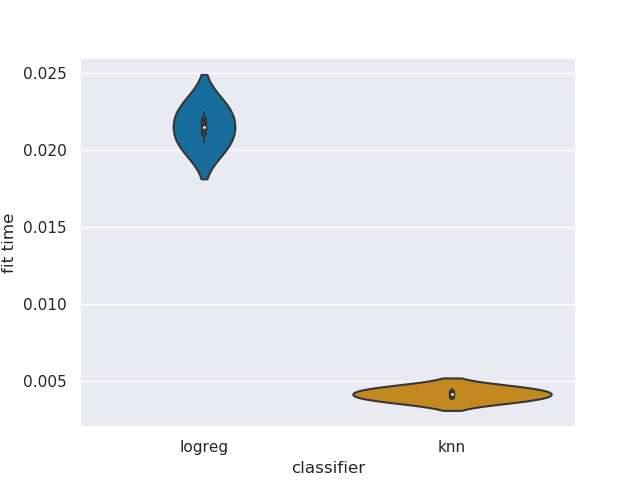

In [437]:
plt.figure()
sns.violinplot(x='classifier', y="fit time", data=violin)
plt.show()